In [1]:
import json
import os
import ml_collections
from lightning.pytorch import seed_everything
from seisLM.model.foundation.pretrained_models import LitMultiDimWav2Vec2
from seisLM.data_pipeline import collator
from seisLM.data_pipeline import seisbench_dataloaders as dataloaders
import matplotlib.pyplot as plt
import tqdm

# config_path = '/scicore/home/dokman0000/liu0003/projects/seisLM/seisLM/configs/pretrain/pretrain_config_rmsnorm_std_nomean_reduce_codevectors_rope.json'
config_path = '/home/liu0003/Desktop/projects/seisLM/seisLM/configs/pretrain/pretrain_config_layernorm_peak_small_batch_6_datasets.json'
with open(config_path, "r", encoding="utf-8") as f:
  config = json.load(f)
config = ml_collections.ConfigDict(config)
config.data_config.local_batch_size = 128

#### Override config
config.data_config.amp_norm_type = 'std'
print(config)

/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


data_config:
  amp_norm: true
  amp_norm_type: std
  cache_dataset: null
  data_name:
  - ETHZ
  - GEOFON
  - STEAD
  - NEIC
  - InstanceCounts
  - Iquique
  demean: true
  local_batch_size: 128
  prefetch_factor: 2
  training_fraction: 1.0
model_config:
  activation_dropout: 0.0
  apply_spec_augment: true
  attention_dropout: 0.0
  codevector_dim: 256
  contrastive_logits_temperature: 0.1
  conv_bias: true
  conv_dim:
  - 256
  - 256
  conv_embed: true
  conv_kernel:
  - 3
  - 3
  conv_stride:
  - 2
  - 2
  diversity_loss_weight: 0.1
  do_stable_layer_norm: true
  feat_extract_norm: layer
  feat_proj_dropout: 0.0
  feat_quantizer_dropout: 0.0
  hidden_dropout: 0.0
  hidden_size: 240
  initializer_range: 0.02
  input_dim: 3
  intermediate_size: 3072
  layer_norm_eps: 1.0e-05
  layerdrop: 0.0
  mask_feature_length: 10
  mask_feature_min_masks: 0
  mask_feature_prob: 0.0
  mask_time_length: 10
  mask_time_min_masks: 2
  mask_time_prob: 0.65
  num_attention_heads: 12
  num_codevector_grou

In [2]:
seed_everything(config.seed)
model = LitMultiDimWav2Vec2(config)

DEFAULT_NUM_WORKERS = 4

data_collator = \
  collator.DataCollatorForWav2Vec2PretrainingConcatChannelsNoPadding(
      config=config.model_config,
      mask_time_prob=config.training_config.mask_time_prob,
      mask_time_length=config.training_config.mask_time_length,
  )

config.data_config.num_workers = int(
    os.environ.get('SLURM_CPUS_PER_TASK', DEFAULT_NUM_WORKERS))


Seed set to 42


In [3]:
all_data_name = [
      "ETHZ",
      "GEOFON",
      "STEAD",
      "NEIC",
      "InstanceCounts",
      "Iquique"
    ][::-1] # 'ETHZ', 'GEOFON'


for data_name in all_data_name:
  print(f'Processing {data_name}')
  train_loader, dev_loader = dataloaders.prepare_seisbench_dataloaders(
    model=model,
    training_fraction=config.data_config.training_fraction,
    data_names=[data_name],
    batch_size=config.data_config.local_batch_size,
    num_workers=config.data_config.num_workers,
    prefetch_factor=config.data_config.prefetch_factor,
    collator=data_collator,
    cache=config.data_config.cache_dataset,
  )

  for (loader_type, loader) in [('train', train_loader), ('dev', dev_loader)]:
    max_input_values = 0.0
    idx = 0
    for batch in tqdm.tqdm(loader):
      input_values = batch['input_values']
      curr_max = input_values.abs().max().item()
      if curr_max > max_input_values:
        max_input_values = curr_max

      if max_input_values > 100:
        print(f'{loader_type} dataset {data_name} abnormal max_input_values: {max_input_values} > 100 at idx {idx}; break \n')
        break
      idx += 1
    print(f'{loader_type} dataset {data_name} max_input_values: {max_input_values} \n')

2024-08-07 18:50:13,604 | seisbench | WARNING | Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb


Processing Iquique


  5%|▍         | 3/62 [00:01<00:25,  2.31it/s]

train dataset Iquique abnormal max_input_values: 915527.3125 > 100 at idx 3; break 



train dataset Iquique max_input_values: 915527.3125 



100%|██████████| 11/11 [00:01<00:00,  6.08it/s]


dev dataset Iquique max_input_values: 22.22224998474121 

Processing InstanceCounts


In [ ]:
for sample in batch['input_values']:
  if sample.abs().max().item() > 100:
    plt.figure()
    print('abnormal sample')
    plt.plot(sample)
    plt.show()
    break



In [ ]:
batch

{'input_values': tensor([[[-1.1175e+00, -1.1119e+00, -1.1071e+00,  ..., -1.1940e+00,
           -1.1826e+00, -1.1812e+00],
          [-1.3297e+00, -1.3305e+00, -1.3496e+00,  ..., -8.7952e-01,
           -8.6932e-01, -8.7770e-01],
          [ 4.2838e-01,  3.9289e-01,  3.5089e-01,  ...,  4.4056e-02,
            5.0940e-02,  3.5437e-02]],
 
         [[ 9.4907e-01,  1.2515e+00,  1.1884e+00,  ..., -6.1390e-01,
           -6.0757e-01, -5.9697e-01],
          [ 7.7131e-01,  4.7331e-01,  4.3946e-01,  ..., -1.7774e-02,
           -3.1697e-02, -3.3050e-02],
          [ 3.1224e-01,  3.6238e-01,  1.4467e-01,  ...,  9.9785e-01,
            1.0061e+00,  9.9733e-01]],
 
         [[-1.0220e+00, -1.0045e+00, -9.8815e-01,  ...,  1.0621e-01,
            1.0824e-01,  1.1573e-01],
          [-1.4961e-01, -1.5218e-01, -1.7604e-01,  ...,  7.3500e-01,
            7.2723e-01,  7.3460e-01],
          [ 8.1299e-01,  8.0549e-01,  7.9224e-01,  ...,  1.0644e+00,
            1.0767e+00,  1.0957e+00]],
 
         ...

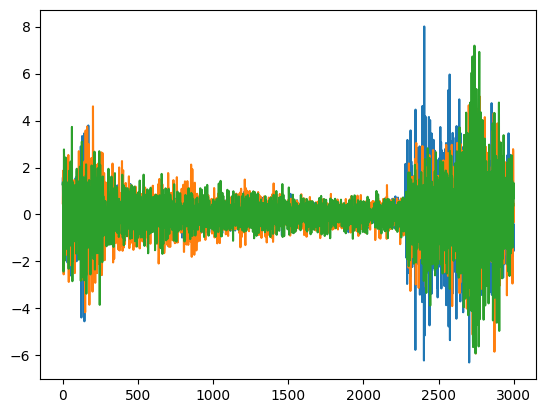

In [ ]:
plt.plot( (input_values[idx] / input_values[idx].std()).T)

In [ ]:
batch['input_values'].abs().max()

tensor(30.2395)

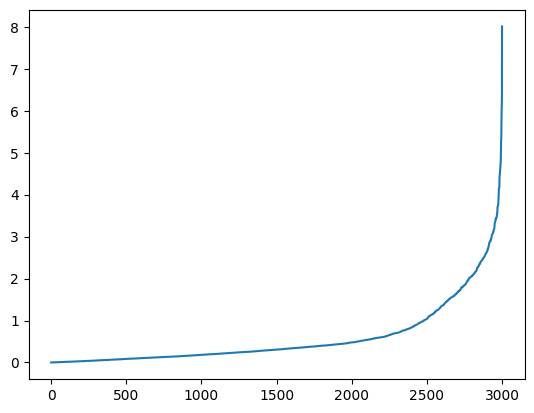

In [ ]:
plt.plot(
  batch['input_values'][idx][0].abs().sort().values
)

In [ ]:
input_values[idx]

tensor([[ 1.2963,  1.5747,  0.4143,  ..., -0.6574, -1.5620, -0.4392],
        [ 0.4769,  0.9572,  1.8635,  ...,  0.6104, -0.3456,  0.4496],
        [ 1.2794,  1.3666,  0.7759,  ...,  1.3190,  1.3465,  0.6936]])

In [ ]:
len(train_loader)

176